In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('Processed Property Data.csv')
df.head()

,Price,Date_Sold,Tenure_Type,New_Build,Address,Property_Type,Num_Bedrooms,Floorplan,Latitude,Longitude,Post_Code,Road_Name,Year_Sold
0,720050,17 Dec 2021,Freehold,False,"11, Whitney Road, London, Greater London E10 7HG",Terraced,3.0,True,51.57167,-0.01677,E10 7HG,Whitney Road,2021
1,445000,12 Aug 2015,Freehold,False,"11, Whitney Road, London, Greater London E10 7HG",Terraced,3.0,True,51.57167,-0.01677,E10 7HG,Whitney Road,2015
2,643756,9 Dec 2021,Freehold,False,"82, Manor Road, Leyton, London, Greater London...",Terraced,4.0,True,51.57082,-0.01955,E10 7HN,Manor Road,2021
3,355000,7 Sep 2007,Freehold,False,"82, Manor Road, Leyton, London, Greater London...",Terraced,4.0,True,51.57082,-0.01955,E10 7HN,Manor Road,2007
4,220000,23 Mar 2006,Freehold,False,"82, Manor Road, Leyton, London, Greater London...",Terraced,4.0,True,51.57082,-0.01955,E10 7HN,Manor Road,2006


In [3]:
df.drop('Address',axis=1,inplace=True)

In [4]:
df = df[df['Year_Sold']>2017]

After testing of results with different combinations of features, the features below have been removed for optimisation of model performance.

In [5]:
df.drop(['Date_Sold','Floorplan','Road_Name','Post_Code','New_Build','Latitude','Longitude'],axis=1,inplace=True)
df.head()

,Price,Tenure_Type,Property_Type,Num_Bedrooms,Year_Sold
0,720050,Freehold,Terraced,3.0,2021
2,643756,Freehold,Terraced,4.0,2021
5,504000,Leasehold,Flat,2.0,2021
7,714000,Freehold,Terraced,3.0,2021
12,540000,Leasehold,Flat,3.0,2021


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 617 entries, 0 to 1555
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price          617 non-null    int64  
 1   Tenure_Type    617 non-null    object 
 2   Property_Type  617 non-null    object 
 3   Num_Bedrooms   617 non-null    float64
 4   Year_Sold      617 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 28.9+ KB


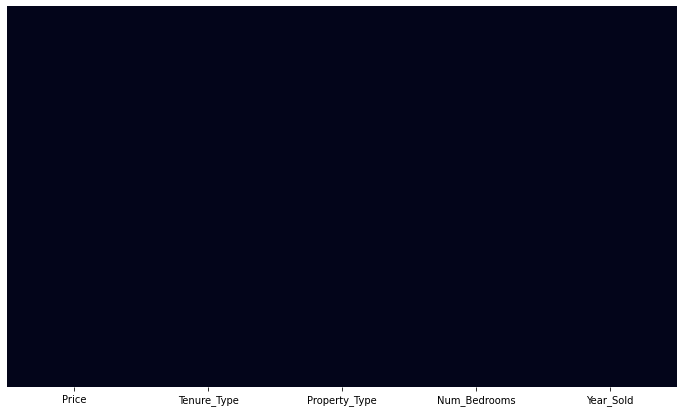

In [7]:
plt.figure(figsize=(12,7))
axis = sns.heatmap(df.isnull(),cbar=False,yticklabels=False)

There are no missing values so I will go ahead and train the ML models

## Data Preprocessing

### Convert Datatypes (Categoric -> Numeric Data)

One hot encoding converting categorical features into encoded form of 0 and 1

In [8]:
df = pd.get_dummies(df, drop_first = True)
df.head()

,Price,Num_Bedrooms,Year_Sold,Tenure_Type_Leasehold,Property_Type_Flat,Property_Type_Semi-Detached,Property_Type_Terraced
0,720050,3.0,2021,0,0,0,1
2,643756,4.0,2021,0,0,0,1
5,504000,2.0,2021,1,1,0,0
7,714000,3.0,2021,0,0,0,1
12,540000,3.0,2021,1,1,0,0


### Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df.drop('Price',axis=1).copy()
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3)

### Scaling the Data
Since it is a regression problem, I will normalise the data. This makes the model more robust and the features will all be in the same axis.

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Training the Model

I will be training a linear regression model and a random forest model optimised by grid search. I will choose the model with the lowest error rate to produce the predictive function.
### Training a Linear Regression model

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
linear_model = LinearRegression()

In [18]:
linear_model.fit(X_train,y_train)

LinearRegression()

In [19]:
print(linear_model.intercept_)

289082.4942049341


In [20]:
coeff_df = pd.DataFrame(linear_model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Num_Bedrooms,304505.957085
Year_Sold,88914.527252
Tenure_Type_Leasehold,-88515.984867
Property_Type_Flat,71585.085028
Property_Type_Semi-Detached,77463.089303
Property_Type_Terraced,80158.053529


#### Evaluating the model

In [21]:
linear_predictions = linear_model.predict(X_test)

<AxesSubplot:xlabel='Price'>

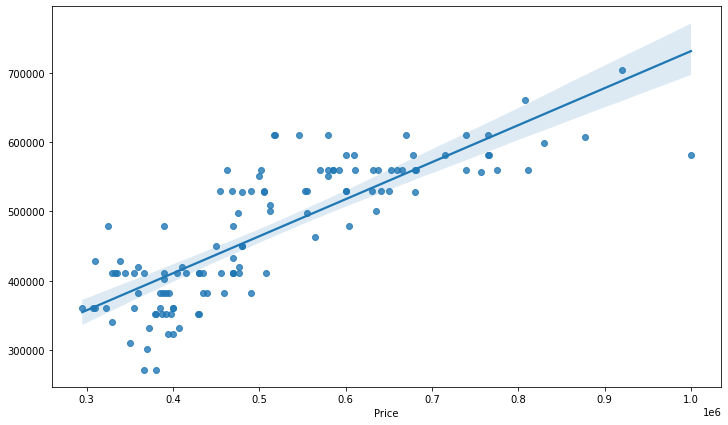

In [22]:
plt.figure(figsize=(12,7))
sns.regplot(x=y_test,y=linear_predictions)

In [23]:
from sklearn import metrics

In [24]:
print('MAE:', metrics.mean_absolute_error(y_test, linear_predictions))
print('MSE:', metrics.mean_squared_error(y_test, linear_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, linear_predictions)))

MAE: 72990.38552907069
MSE: 9384420451.541386
RMSE: 96873.2184431868


### Training a Random Forest Model

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
test_rforest_model = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={'min_samples_leaf':[1,2,3,4,5,10,20,50,100]}, 
)
test_rforest_model.fit(X_train,y_train)

In [39]:
test_rforest_pred = test_rforest_model.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


<AxesSubplot:xlabel='Price'>

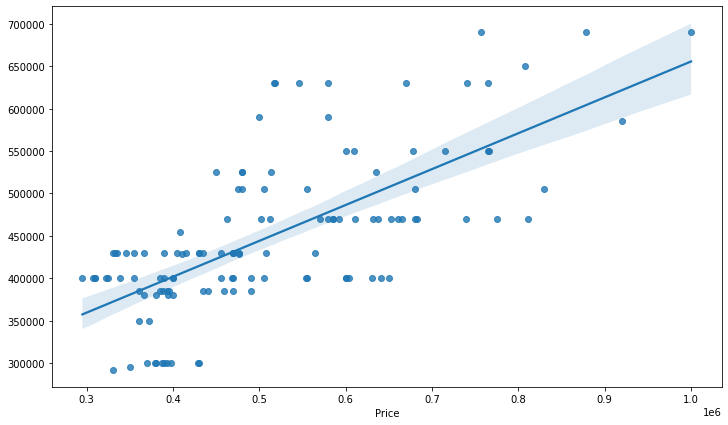

In [40]:
plt.figure(figsize=(12,7))
sns.regplot(x=y_test,y=test_rforest_pred)

In [26]:
rforest_model = RandomForestClassifier()

In [27]:
rforest_model.fit(X_train,y_train)

RandomForestClassifier()

In [28]:
rforest_pred = rforest_model.predict(X_test)

### Evaluating the model

<AxesSubplot:xlabel='Price'>

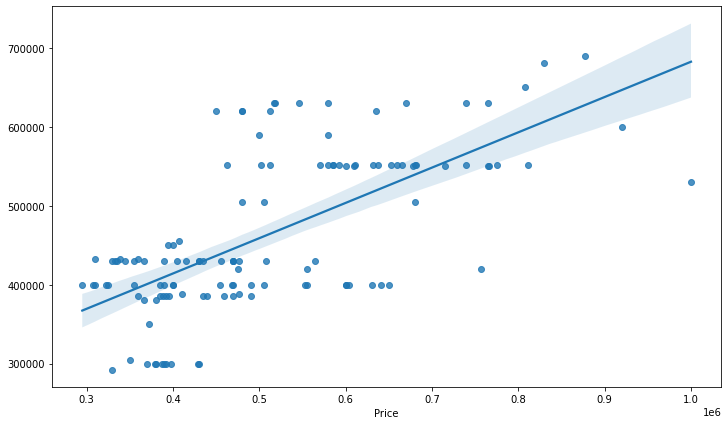

In [29]:
plt.figure(figsize=(12,7))
sns.regplot(x=y_test,y=rforest_pred)

In [30]:
print('MAE:', metrics.mean_absolute_error(y_test, rforest_pred))
print('MSE:', metrics.mean_squared_error(y_test, rforest_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rforest_pred)))

MAE: 92288.94354838709
MSE: 14374042753.879032
RMSE: 119891.79602407762


In [31]:
model_metric = {'Random Forest':[metrics.mean_absolute_error(y_test, rforest_pred),metrics.mean_squared_error(y_test, rforest_pred),np.sqrt(metrics.mean_squared_error(y_test, rforest_pred))],
'Linear Regression':[metrics.mean_absolute_error(y_test, linear_predictions),metrics.mean_squared_error(y_test, linear_predictions),np.sqrt(metrics.mean_squared_error(y_test, linear_predictions))]}

## Choosing the model

In [32]:
pd.DataFrame(model_metric,columns=['Linear Regression','Random Forest'],index=['MAE','MSE','RMSE'])

,Linear Regression,Random Forest
MAE,7.299039e+04,9.228894e+04
MSE,9.384420e+09,1.437404e+10
RMSE,9.687322e+04,1.198918e+05


As the linear regression model has the lowest error rate for all metrics, I will be using the model for the prediction function

## Prediction for user's property price

In [ ]:
def predict_user():
    print('Features Selected ')
    while True:
        try:
            num_bed = int(input('How many bedrooms does the property have? '))
        except:
            print('Sorry must be an integer')
        else:
            print('Number of bedrooms: ',num_bed)
            break
             
    tenure = input('What type of tenure type does the property have? press L for leasehold and F for freehold')
    if tenure.lower() == 'l':
        tenure = 1
        ten = 'Leasehold'
    else:
        tenure = 0
        ten = 'Freehold'
    print('Tenure Type: ',ten)

    while True:
        try:
            prop = int(input('What is the type of the property? 1 for Flat, 2 for Terraced, 3 for Semi-Detached and 4 for Detached'))
        except:
            print('Sorry error, please between 1 to 4')
        else:
            if prop == 1:
                num_list = [1,0,0,0]
                p = 'Flat'
            elif prop == 2:
                num_list = [0,1,0,0]
                p = 'Terraced'
            elif prop == 3:
                num_list = [0,0,1,0]
                p = 'Semi_detached'
            else:
                num_list = [0,0,0,1]
                p = 'Detached'

            print('Property Type: ',p)
            break

    user_dict = {'Num_Bedrooms':num_bed,'Year_Sold':2021,'Tenure_Type_Leasehold':tenure,'Property_Type_Flat':num_list[0],'Property_Type_Semi-Detached':num_list[2],'Property_Type_Terraced':num_list[1]}
    user_data = pd.DataFrame(user_dict, index=[0])
    print(('Your property has a predicted cost of £{}'.format(round(linear_model.predict(user_data)[0]))))

In [ ]:
predict_user()

Features Selected 
Sorry must be an integer
Number of bedrooms:  2
Tenure Type:  Leasehold
Property Type:  Terraced
Your property has a predicted cost of £445766
